In [1]:
import os
import pandas as pd
import numpy as np
import pickle

from sklearn.utils.class_weight import compute_class_weight
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import *

from keras import optimizers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, Callback

import matplotlib.pyplot as plt
plt.style.use('seaborn')

Using TensorFlow backend.


---

### First, copy-paste the setup from the notebook that produced the pretrained classweights.
This time we load also the test-data into memory
(Note to self: learn how to make imports from other notebooks...)

In [2]:
global_params = pickle.load(open("global_params.p", "rb"))
unique_words = global_params['unique_words']
num_words = global_params['num_words']
padded_length = global_params['padded_length']
n_classes = global_params['n_classes']
class_weights = global_params['class_weights']

global_params

{'unique_words': 277303,
 'num_words': 277304,
 'padded_length': 679,
 'n_classes': 6,
 'class_weights': array([ 1.26825655,  0.72736371,  0.27602776, 13.23801959, 30.29201502,
         9.49559404])}

In [5]:
n_sample=100_000

In [6]:
X_train = np.load(os.path.join("data", "Kdata", "X_train.npy"))[-n_sample:]
y_train = np.load(os.path.join("data", "Kdata", "y_train.npy"))[-n_sample:]
X_val = np.load(os.path.join("data", "Kdata", "X_val.npy"))[-n_sample:]
y_val = np.load(os.path.join("data", "Kdata", "y_val.npy"))[-n_sample:]
X_test = np.load(os.path.join("data", "Kdata", "X_test.npy"))
y_test = np.load(os.path.join("data", "Kdata", "y_test.npy"))

### Start of boilerplate

In [14]:
from keras import backend as K

# Custom metrics.
# Note that any metric is computed per batch during training
# (hence one needs large batches for it to make sense).
# Also, there is the implicit 0.5 treshold in the K.round function below

def macroPrec(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    positives = K.sum(K.round(y_pred), axis=0)
    precision = true_positives / (positives + K.epsilon())

    macroPrec = K.mean( precision )
    
    return macroPrec


def macroRecall(y_true, y_pred):
    
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    macroRecall = K.mean( recall )
    
    return macroRecall


def macroF1(y_true, y_pred):

    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)), axis=0)
    
    actual_ones = K.sum(K.round(K.clip(y_true, 0, 1)), axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    return macroF1



# Custom loss functions
# No clippping or rounding as those are not differentiable
# Note to self: these functions are already taking into account class imbalances, so remeber
# not to set the class_weight argument in fitting method when using them as the loss 

# semi macroF1
def fuzzy_macroF1_flip(y_true, y_pred):

    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1 = 2 * K.mean( precision*recall / (precision + recall + K.epsilon()) ) 
    
    return 1-macroF1


# # weighted categorical crossentropy
# def my_crossE(y_true, y_pred):
    
#     class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
#     weighted_entropy = K.mean(class_weights * class_entropy)
#     return -4E-4 * weighted_entropy  # arbitrary coefficient to make it close to [0-1] interval


# take average of the last two, because why not
def my_loss(y_true, y_pred):
    # return 0.5*(fuzzy_macroF1_flip(y_true, y_pred) + my_crossE(y_true, y_pred))
    
    true_positives = K.sum(y_true * y_pred, axis=0)
    
    actual_ones = K.sum(y_true, axis=0)
    recall = true_positives / (actual_ones + K.epsilon())

    positives = K.sum(y_pred, axis=0)
    precision = true_positives / (positives + K.epsilon())
    
    macroF1p2 = K.mean( precision*recall / (precision + recall + K.epsilon()) )
    
    class_entropy = K.sum(y_true * K.log(y_pred+K.epsilon()), axis=0)
    weighted_entropy = K.mean(class_weights * class_entropy)
    
    return 0.5 - macroF1p2 - 2E-4 * weighted_entropy

In [41]:
# auxiliary functions
    

# to plot the learning history,
# i.e. loss and metrics on each train_batch and validation_batch
def plot_history(history):
    
    plt.figure(figsize=(18, 5))
    
    loss = history['loss']
    val_loss = history['val_loss']
    x = range(1, len(loss) + 1)
    
    plt.subplot(1, 3, 1)    
    plt.plot(x, loss, 'ob', label='Training loss')
    plt.plot(x, val_loss, '-b', label='Validation loss')
    plt.title('Training and val losses') 
    plt.legend()
    
    all_metrics = np.array(list(set(history.keys()) - set(['loss', 'val_loss', 'lr'])))
    metrics = all_metrics[[not metric.startswith('val_') for metric in all_metrics]]
    plt.subplot(1, 3, 2)
    markers = ['b', 'r',  'g', 'y', 'm', 'c', 'k']
    marker = zip(markers, markers)
    for metric in metrics:
        results = history[metric]
        val_results = history['val_'+metric]
        mark1, mark2 = next(marker)
        plt.plot(x, results, 'o'+mark1, label=metric)
        plt.plot(x, val_results, '-'+mark2, label='Validation '+metric)
        plt.title('Training and val metrics')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    lr = history['lr'] # learning rate
    plt.plot(x, lr, 'k', label='Learning rate')
    plt.title('Learning rate')  
    plt.legend()
    

# choose callbacks to be given in model.fit(...)
class WakeEmbedding(Callback):
    
    def __init__(self, rel_lr_treshold):
        self.rel_lr_treshold = rel_lr_treshold
    
    def on_train_begin(self, logs={}):
        self.init_lr =  K.eval(self.model.optimizer.lr)
        
    def on_epoch_begin(self, epoch, logs={}):
        lr =  K.eval(self.model.optimizer.lr)
        if (lr / self.init_lr) <= self.rel_lr_treshold:
            self.model.layers[0].trainable = True
        print("Embedding trainable:", self.model.layers[0].trainable)


def callbacks(plateau_factor=0.5, plateau_patience=1,\
              early_s_patience = 2,\
              waking0th=True, wake_treshold = 0.5
             ):
    
    callbacks = [ReduceLROnPlateau(factor=plateau_factor,\
                                   monitor='val_macroF1', mode='max', patience = plateau_patience),
                EarlyStopping(monitor='val_macroF1', mode='max', patience=early_s_patience)
               ]
    
    return callbacks + [WakeEmbedding(wake_treshold)] if waking0th else callbacks


# callbacks = [ReduceLROnPlateau(factor=0.5,\
#                                monitor='val_macroF1', mode='max', patience = 1),
#              EarlyStopping(monitor='val_macroF1', mode='max', patience=2),
#             WakeEmbedding(0.5)
#            ]


# some other global learning settings

batch_size = 3000
# defualt lr = 0.001
optimizer = optimizers.Adam(lr=0.002, beta_1=0.9, beta_2=0.999,\
                            epsilon=None, decay=0.0, amsgrad=False)
my_metrics = [macroPrec, macroF1, macroRecall] #, my_crossE, fuzzy_macroF1_flip, my_loss]

Take not of the ***WakeEmbedding()*** callback, which is meant to unfreeze the embedding layer when the *ReduceOnPlateau* drops the learning rate by a certain factor (possibly already directly after the firts intervention of *ReduceOP*).

---

In [61]:
# the workhorse

class BlackBox():
    
    def __init__(self, layers, loss, metrics, callbacks=callbacks(), class_weight=class_weights, epochs=3,\
                 embedd = None, embedd_dims=[None]*3, train_weights=False):
        
        self.layers = layers
        self.loss = loss
        self.metrics = metrics
        self.callbacks = callbacks
        self.class_weight = class_weight
        self.epochs = epochs
        self.train_weigts = train_weights
        self.history = None
        self.test_results = None
        
        self.model = Sequential()
        if embedd:
            self.input_dim = embedd_dims[0] # num_words
            self.output_dim = embedd_dims[1] # dimension of the embedding space
            self.input_length = embedd_dims[2] # padded_length
            with open(embedd, "rb") as f:
                self.embedd_weights = pickle.load(f)
            
            self.model.add(Embedding(input_dim=self.input_dim,\
                                     output_dim=self.output_dim,\
                                     input_length=self.input_length,\
                                     weights=self.embedd_weights,\
                                     trainable=self.train_weigts,\
                                     mask_zero=True
                                    )
                          )
            self.model.layers[0].trainable = self.train_weigts  # szczeżonego panbug szczeże
            
        for layer in layers:
            self.model.add(layer)
            
        self.model.add(Dense(n_classes, activation='softmax'))
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
    
    def summary(self):
        return self.model.summary()
    
    def fit(self, epochs=50):
        self.history = self.model.fit(
            X_train, y_train,
            class_weight=self.class_weight,
            epochs=self.epochs,
            batch_size=batch_size,
            #validation_split=0.1,
            validation_data=(X_val, y_val),
            callbacks=self.callbacks,
            verbose = 1        
            )
        
    def reset(self):
        
        self.history = None
        self.test_results = None
        self.model.compile(loss=self.loss, optimizer=optimizer, metrics=self.metrics)
        
    def evaluate(self, X_test, y_test):
        print(f'Loss function: {self.loss.__name__ if callable(self.loss) else self.loss}. Metrics: {[metric.__name__ if callable(metric) else metric for metric in self.metrics]}')
        print("Predicting for X_test, comparing with y_test")
        self.test_results = self.model.evaluate(X_test, y_test)
        return self.test_results
    
    def plot(self):
        plot_history(self.history.history)
        
    def save_embedd(self, name):
        file = os.path.join("my_embeddings", f"weights_{name}.p")
        with open(file, 'wb') as f:
            pickle.dump(self.model.layers[0].get_weights(), f)
        
    def Ksave(self, name):
        file = os.path.join("my_embeddings", f"Kmodel_from_{name}.h5")
        self.model.save(file)
    
    def save_hist(self, name):
        file = os.path.join("my_embeddings", f"history_of_{name}.p")
        with open(file, 'w') as f:
            json.dump(self.history.history, f) 


In [31]:
custom_objects={'macroPrec': macroPrec,\
                'macroF1': macroF1,\
                'macroRecall': macroRecall,\
#                 'my_crossE': my_crossE,\
                 'fuzzy_macroF1_flip': fuzzy_macroF1_flip,\
                'my_loss': my_loss
               }

### End of boilerplate

---
---

In [12]:
# embedd_file_1 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_CatCrossE_10epochs.p")
# embedd_file_2 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_F1flip_10epochs.p")
# embedd_file_3 = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

---
---

In [56]:
# # dense net

# layers1 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length),
#             Dense(50, activation='relu'),
#             MaxPooling1D(4, 2),
#             Dropout(0.1),
#             Dense(50, activation='relu'),
#             MaxPooling1D(4, 2),
#             Dropout(0.1),
#             Flatten()
#            ]

# model1 = BlackBox(layers=layers1, loss="categorical_crossentropy", class_weight=class_weights,\
#                   metrics=my_metrics,\
#                   callbacks=callbacks(waking0th=False),\
#                   epochs=20
#                  )

# model1.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
dense_26 (Dense)             (None, 679, 50)           2550      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 338, 50)           0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 338, 50)           0         
_________________________________________________________________
dense_27 (Dense)             (None, 338, 50)           2550      
_________________________________________________________________
max_pooling1d_20 (MaxPooling (None, 168, 50)           0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 168, 50)           0         
__________

---
---

In [ ]:
# ConvNets

---

In [ ]:
layers2 = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length),
           Conv1D(40, 4),
           MaxPooling1D(4, 2),
           Dropout(0.1),
           Conv1D(40, 4),
           MaxPooling1D(4, 2),
           Dropout(0.1),
           Flatten()
          ]

model2 = BlackBox(layers=layers2, loss="categorical_crossentropy", class_weight=class_weights,\
                  metrics=my_metrics,\
                  callbacks=callbacks(waking0th=False),\
                  epochs=20
                 )
model2.summary()

---

In [ ]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_CatCrossE_10epochs.p")

layers2a = [Conv1D(40, 4),
            MaxPooling1D(4, 2),
            Dropout(0.1),
            Conv1D(40, 4),
            MaxPooling1D(4, 2),
            Dropout(0.1),
            Flatten()
           ]

model2a = BlackBox(layers=layers2a, loss="categorical_crossentropy", class_weight=class_weights,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model2a.summary()

---

In [ ]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_F1flip_10epochs.p")

layers2b = [SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model2b = BlackBox(layers=layers2b, loss=fuzzy_macroF1_flip, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model2b.summary()

---

In [ ]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

layers2c = [SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model2c = BlackBox(layers=layers2c, loss=my_loss, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length])
model2c.summary()

In [66]:
# There's something wrong with the learning rate. It's supposed to start at *lr=0.02* but seemingly it doesn't (see plots below)

---
---

# Recurrent NNets

### Summary of final *val_macroF1*  obtained by the keras' fully-connected RNNs:
* trained on the 100k sample
* single-directional (-->) on zero-prepadded sequences (\[000...0123\]), 100dim SimpleRNN
* the *mask_zero*=True is set (both here and in creating the embedding)
* no more than 20 epochs (not counting pretraining the embedding)
* large *batch_size* argument

Using the *pretrained embedding* should be a considerable boost, since it was trained on the whole train-data (500k)

$\begin{array}{c|cc}
   {val\_macroF1} & \text{cat. crossentr.} & \textit{my_loss} \\
  \hline
  \text{fresh embedding}   & ? & 49\% \\
    \text{pretrained embedd} & 44\% & 66\% \\
\end{array}$

---

### 1a.
**No pretrained embedding**. Using the standard loss function, **categorical crossentropy**, with explicit **class_weight** argument. In other cases we will use early-stopping but here let's just let it run for the whole of 20 epochs.

In [74]:
layers1a = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model1a = BlackBox(layers=layers1a, loss="categorical_crossentropy", class_weight=class_weights,\
                  metrics=my_metrics,\
                  callbacks=None,\
                  epochs=20
                 )
model1a.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_15 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_16 (SimpleRNN)    (None, 100)               15100     
_________________________________________________________________
dense_17 (Dense)             (None, 6)                 606       
Total params: 13,880,906
Trainable params: 13,880,906
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model1a.fit()

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 783s 8ms/step - loss: 1.8361 - macroPrec: 0.0050 - macroF1: 5.4437e-06 - macroRecall: 2.7233e-06 - val_loss: 1.8006 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 2/20
100000/100000 [==============================] - 732s 7ms/step - loss: 1.8311 - macroPrec: 0.0050 - macroF1: 2.4752e-05 - macroRecall: 1.2407e-05 - val_loss: 1.7964 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 3/20
100000/100000 [==============================] - 799s 8ms/step - loss: 1.8272 - macroPrec: 0.0150 - macroF1: 2.4862e-05 - macroRecall: 1.2444e-05 - val_loss: 1.7932 - val_macroPrec: 0.0000e+00 - val_macroF1: 0.0000e+00 - val_macroRecall: 0.0000e+00
Epoch 4/20
100000/100000 [==============================] - 801s 8ms/step - loss: 1.8227 - macroPrec: 0.0050 - macroF1: 5.5127e-06 - macroRecall: 2.7579e-06 - val_loss:

In [ ]:
model1a.plot()

### Commentary
...

---

### 1b.
Now using the standard loss function, **categorical crossentropy**, with explicit **class_weight** argument,
**and the pretrained embedding** (produced by the same loss function).

In [64]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_CatCrossE_10epochs.p")

layers1b = [SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model1b = BlackBox(layers=layers1b, loss="categorical_crossentropy", class_weight=class_weights,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model1b.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_14 (SimpleRNN)    (None, 100)               15100     
_________________________________________________________________
dense_15 (Dense)             (None, 6)                 606       
Total params: 13,880,906
Trainable params: 15,706
Non-trainable params: 13,865,200
_________________________________________________________________


In [65]:
model1b.fit()

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
Embedding trainable: False
100000/100000 [==============================] - 747s 7ms/step - loss: 1.1372 - macroPrec: 0.3529 - macroF1: 0.1247 - macroRecall: 0.1168 - val_loss: 0.7513 - val_macroPrec: 0.4993 - val_macroF1: 0.2338 - val_macroRecall: 0.2085
Epoch 2/20
Embedding trainable: False
100000/100000 [==============================] - 746s 7ms/step - loss: 0.6897 - macroPrec: 0.5067 - macroF1: 0.2992 - macroRecall: 0.2600 - val_loss: 0.4927 - val_macroPrec: 0.4816 - val_macroF1: 0.3907 - val_macroRecall: 0.3608
Epoch 3/20
Embedding trainable: False
100000/100000 [==============================] - 748s 7ms/step - loss: 0.5430 - macroPrec: 0.5042 - macroF1: 0.3906 - macroRecall: 0.3586 - val_loss: 0.3994 - val_macroPrec: 0.4576 - val_macroF1: 0.4275 - val_macroRecall: 0.4146
Epoch 4/20
Embedding trainable: False
100000/100000 [==============================] - 727s 7ms/step - loss: 0.5216 - macroPrec: 0.4695 - macroF1: 

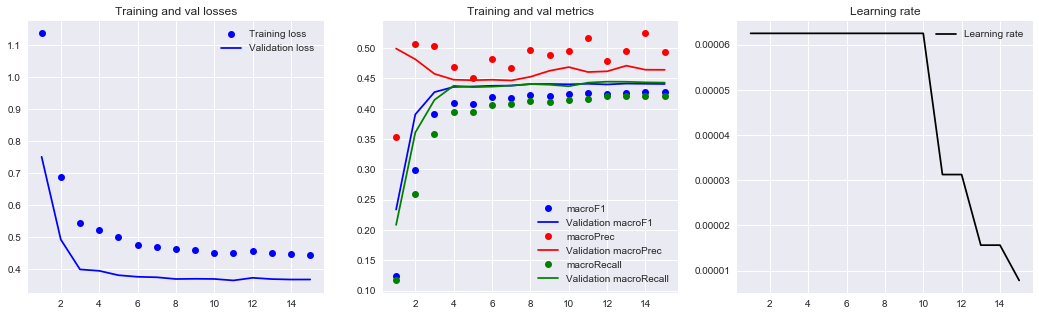

In [69]:
model1b.plot()

### Commentary
Usage of the pretrained ambedding has been visibly helpful but definitely not to a satisfactory level. The highest *val_macroF1* was 44%, reached after 4th epoch and never improved upon. The score is only ... point higher than our first attempt when we were simultaneously taining the embedding.

---

### 1c.
Now we'll use our custom loss function, **my_loss**. This function hits harder when the model assigns low probability to the true class. **class_weight=None**.
The **embedding was pretrained** with the same loss function.

In [ ]:
embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

layers1c = [SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model1c = BlackBox(layers=layers1c, loss=my_loss, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model1c.summary()

In [ ]:
model1c.model.layers[0].mask_zero

In [ ]:
model1c.fit()

In [ ]:
model1c.plot()

### Commentary
Terrifyingly, the validation data is consistently scoring better than the training data, even on the late-time plateau. This shows that the attempts of the test-data to mold the RNN layer are only punishing the performance of the pretrained embedding layer. The val_macroPrec gets glued to 66% very early on, and the other two metrics need about a dozen of epochs to get stuck there as well. After that, our early-stopping (patience=2) kicks in after 5 more epochs. For the first 10 epochs the embedding layer was staying frozen and the RNN was trying very hard to stop encumbering the embedding. After the 10th epoch RNN stopped improving despite the fact that validation data still was performing better that test-data and the embedding unfroze. But the newly gained freedom of adjusting 14 mil. parameters pushed the score less than one percentage point up.

---

### 1d.
Seeing as the RNN didn't work well with the embedding in the above run, this time we'll go back to **not using the pretrained embedding**. (Loss function: **my_loss**; **class_weight=None**.)

In [48]:
layers1d = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
           SimpleRNN(100, dropout=0.1, recurrent_dropout=0.1),
           ]

model1d = BlackBox(layers=layers1d, loss=my_loss, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20,
                   callbacks=callbacks(waking0th=False)
                  )
model1d.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 679, 50)           13865200  
_________________________________________________________________
simple_rnn_12 (SimpleRNN)    (None, 100)               15100     
_________________________________________________________________
dense_13 (Dense)             (None, 6)                 606       
Total params: 13,880,906
Trainable params: 13,880,906
Non-trainable params: 0
_________________________________________________________________


In [49]:
model1d.fit()

Train on 100000 samples, validate on 100000 samples
Epoch 1/20
100000/100000 [==============================] - 728s 7ms/step - loss: 0.6194 - macroPrec: 0.0385 - macroF1: 1.9794e-04 - macroRecall: 9.9759e-05 - val_loss: 0.6132 - val_macroPrec: 0.0150 - val_macroF1: 1.6514e-05 - val_macroRecall: 8.2618e-06
Epoch 2/20
100000/100000 [==============================] - 761s 8ms/step - loss: 0.6047 - macroPrec: 0.1799 - macroF1: 0.0134 - macroRecall: 0.0074 - val_loss: 0.5896 - val_macroPrec: 0.2938 - val_macroF1: 0.0884 - val_macroRecall: 0.0580
Epoch 3/20
100000/100000 [==============================] - 828s 8ms/step - loss: 0.5559 - macroPrec: 0.3169 - macroF1: 0.1682 - macroRecall: 0.1350 - val_loss: 0.5174 - val_macroPrec: 0.4121 - val_macroF1: 0.2499 - val_macroRecall: 0.2142
Epoch 4/20
100000/100000 [==============================] - 825s 8ms/step - loss: 0.5225 - macroPrec: 0.4063 - macroF1: 0.2332 - macroRecall: 0.1979 - val_loss: 0.5098 - val_macroPrec: 0.4011 - val_macroF1: 0.265

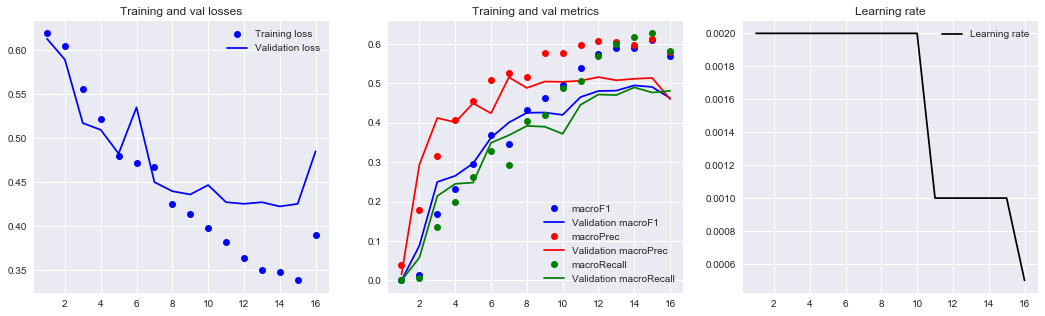

In [57]:
model1d.plot()

### Commentary
This time at later epochs the test-data reaches higher scores than validation data, as one would expect. But it does not even reach 50%. The *val_macroF1* maxes out at abysmal 49% and goes down to 46% before the early-stopping kicks in. 

---
---

## TODO:
* Repeat for Long-Short-Term-Memory
* Find a better embedding

---

In [ ]:
# categorical crossentropy + fresh embedding

layers4a = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
            LSTM(20, dropout=0.0, recurrent_dropout=0.0)
           ]

model4a = BlackBox(layers=layers4a, loss="categorical_crossentropy", class_weight=class_weights,\
                  metrics=my_metrics,\
                  callbacks=callbacks(waking0th=False),\
                  epochs=20
                 )
model4a.summary()

---

In [ ]:
# categorical crossentropy + sleeping embedding

embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_CatCrossE_10epochs.p")

layers4b = [LSTM(20, dropout=0.0, recurrent_dropout=0.0),
           ]

model4b = BlackBox(layers=layers4b, loss="categorical_crossentropy", class_weight=class_weights,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model4b.summary()

---

In [ ]:
# my_loss + fresh embedding

layers4c = [Embedding(input_dim=num_words, output_dim=50, input_length=padded_length, mask_zero=True),
            LSTM(20, dropout=0.0, recurrent_dropout=0.0)
           ]


model4c = BlackBox(layers=layers4c, loss=my_loss, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20
                  )
model4c.summary()

---

In [19]:
# my_loss + sleeping embedding

embedd_file = os.path.join("my_embeddings", "weights_50dim_GlblAvg_MyLoss_10epochs.p")

layers4c = [LSTM(20, dropout=0.0, recurrent_dropout=0.0),
           ]

model4c = BlackBox(layers=layers4c, loss=my_loss, class_weight=None,\
                   metrics=my_metrics,\
                   epochs=20,\
                   embedd = embedd_file,\
                   embedd_dims=[num_words, 50, padded_length]
                  )
model4c.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 679, 50)           13865200  
_________________________________________________________________
lstm_4 (LSTM)                (None, 20)                5680      
_________________________________________________________________
dense_4 (Dense)              (None, 6)                 126       
Total params: 13,871,006
Trainable params: 5,806
Non-trainable params: 13,865,200
_________________________________________________________________


---
---